In [1]:
import torch
torch.manual_seed(0)
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from monotonic import MonotonicMLP, ConstrainedMLP

In [2]:
def train(models, hard=True, plot=True, device='cuda', steps=1000, lr=0.01):
    # define the target
    x = torch.linspace(-2, 2, 1024).unsqueeze(-1).to(device)
    target = (
        torch.where(x>0, torch.sin(6.28*x)/6.28+x, 0.5+x.floor()) 
        if hard else 
        torch.sign(x)*x**2
    )

    # train loops
    losses = {model: [] for model in models.keys()}
    for name, model in models.items():
        model = model.to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        for i in (pbar:=tqdm(range(steps))):
            loss = ((model(x) -target)**2).mean()
            opt.zero_grad()
            loss.backward()
            opt.step()
            losses[name].append(loss.item()**0.5)
            if i%10==0:
                pbar.set_postfix({'rmse': sum(losses[name][-10:])/10})

    if plot:
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.plot(x.cpu(), target.cpu(), "k", label='target')
        for name, model in models.items():
            y = model(x).detach().cpu()
            plt.plot(x.cpu(), y, label=f'{name} (rmse={losses[name][-1]**0.5:.2f})')
        plt.grid()
        plt.legend()
        plt.subplot(122)
        for (name), loss in losses.items():
            plt.semilogy(loss, label=name)
        plt.legend()
        plt.grid()
        plt.show()

# Monotonicity and Convexity

given an activation function $act(\cdot)$, a constrained MLP is a trasformation given by:
$$ f = L_n \circ act \circ L_{n-1} \circ \dots act \circ L_0 $$
Where $L_i$ are monotonic non decreasing affine trasformations parametrized by $W_i, b_i$ (with $W_i>=0$)

A sufficient condition for monotonicity of $f(x)$, is that the activation function $act(\cdot)$ is also monotonic.
Moreover, if $act(\cdot)$ is also convex, then $f(x)$ will also be convex.

This property allows us to parametrize monotonic convex network, however in most scenarios, being able to approximate only convex functions is not a desiderable proprerty.

A key observation is that, if $act(z)$ is convex, then $-a(-z)$ is concave, but has the same monotonicity. 
In the context of a NN, this transformation means "flipping" the weights of the neurons before and after the activation.

Therefore if we separate the weights $W_i$ into positive and negative parts ($W_i = W_i^+ - W_i^-$) we can parametrize the linear layer as:
$$ W_i^+ act(x) - W_i^- act(-x) $$
This is a monotone transformation, without the need to reparametrize the weight matrix $W_i$, and can be either convex, concave or neither depending on the weights values.

One interesting quirk of the sigmoid function is that $\sigma(x) = -\sigma(-x) +c$ making our construction equivalent to a constrained MLP when the activation function is the sigmoid function.

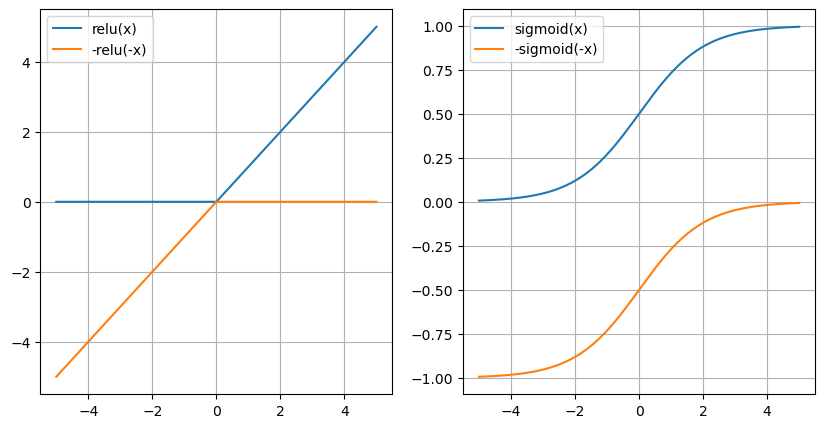

In [3]:
x = torch.linspace(-5, 5, 1000)
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(x, torch.relu(x), label='relu(x)')
plt.plot(x, -torch.relu(-x), label='-relu(-x)')
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(x, torch.sigmoid(x), label='sigmoid(x)')
plt.plot(x, -torch.sigmoid(-x), label='-sigmoid(-x)')
plt.grid()
plt.legend()
plt.show()

# Universal approximation

A 1 layer constrained MLP with monotonic activation function $f(x)$
is a universal approximator if  $$f(W x) \approx H(x)$$

For $f(x)=\sigma(x)=\frac{1}{1+exp(-x)}$, this property holds.

However, optimizing a sigmoid activated MLP is not trivial when the target function is complex.
Indeed we can see that large net struggle to learn even very simple functions.

100%|██████████| 10000/10000 [00:37<00:00, 267.60it/s, rmse=0.449]


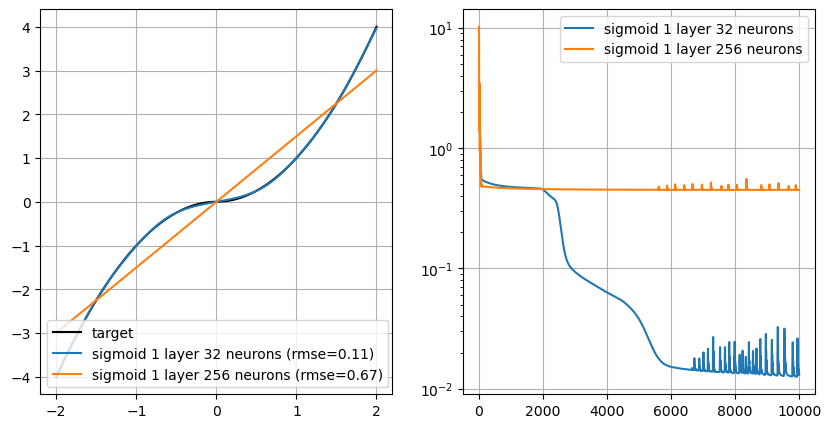

100%|██████████| 10000/10000 [00:50<00:00, 197.89it/s, rmse=0.199]


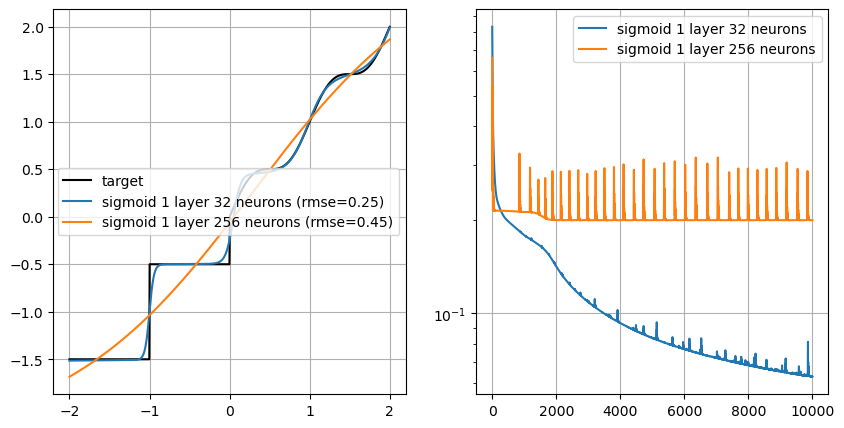

In [4]:
models = {
    "sigmoid 1 layer 32 neurons": MonotonicMLP(
        dims=(1, 32, 1), 
        activation=nn.Sigmoid(),
    ),
    "sigmoid 1 layer 256 neurons": MonotonicMLP(
        dims=(1, 256, 1), 
        activation=nn.Sigmoid(),
    ),
}
train(models, hard=False, lr=0.01, steps=10000)
train(models, hard=True, lr=0.01, steps=10000)

The same is not true for non saturating activations (ReLU like functions).
Activations of this kind are unable to approximate the Heaviside with a positive linear combination of the inputs.

However, composing two layers it is possible to approximate an heavyside function arbitrary well.
This ensures that an MLP with 2 hidden layers is an universal function approximator, when using RELU and similar non saturating functions.

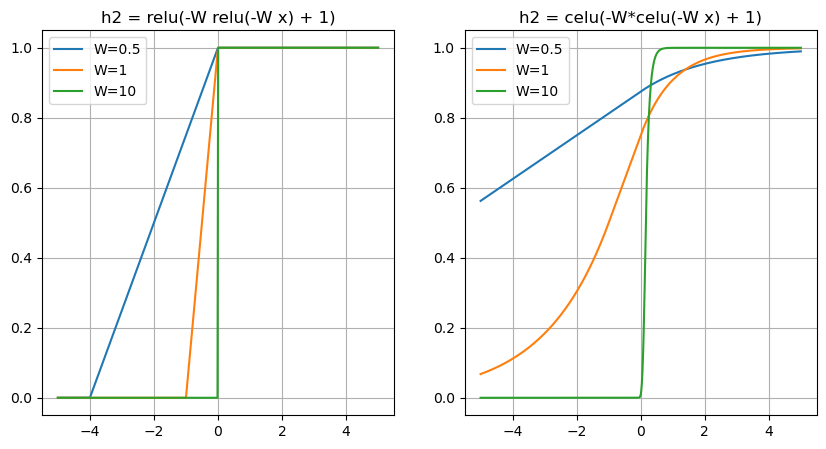

In [5]:
x = torch.linspace(-5, 5, 1000)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('h2 = relu(-W relu(-W x) + 1)')
act = torch.relu
for W in [0.5, 1, 10]:
    h1 = -act(-W*x)
    h2 = act(W*h1+1)
    plt.plot(x, h2, label=f'W={W}')
plt.grid()
plt.legend()

plt.subplot(122)
plt.title('h2 = celu(-W*celu(-W x) + 1)')
# The same works for CELU, but the params are less intuitive
act = lambda x:(torch.celu(x)+1)/2 
for W in [0.5, 1, 10]:
    h1 = -act(-W*x)
    h2 = act(W*h1+1)
    plt.plot(x, h2, label=f'W={W}')
plt.grid()
plt.legend()

plt.show()

Indeed we can see that while 1 layer is enought to learn the simple target function, it is unable to learn a more complex one. However 2 hidden layers provide an universal approximator, and indeed are able to learn the complex target. 

In contrast to the sigmoid activated networks, since the ReLU family of activations does not have vanishing gradients, the optimization is more stable and it is easier to optimize larger networks.

100%|██████████| 10000/10000 [01:10<00:00, 142.30it/s, rmse=0.00488]


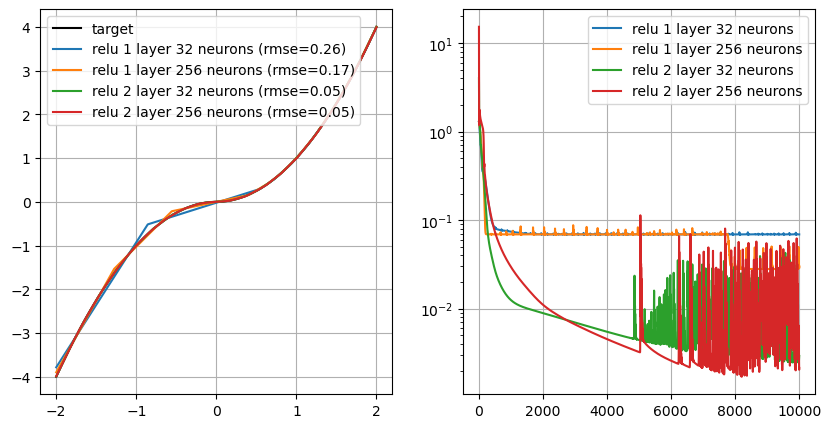

100%|██████████| 10000/10000 [01:05<00:00, 153.54it/s, rmse=0.0626]


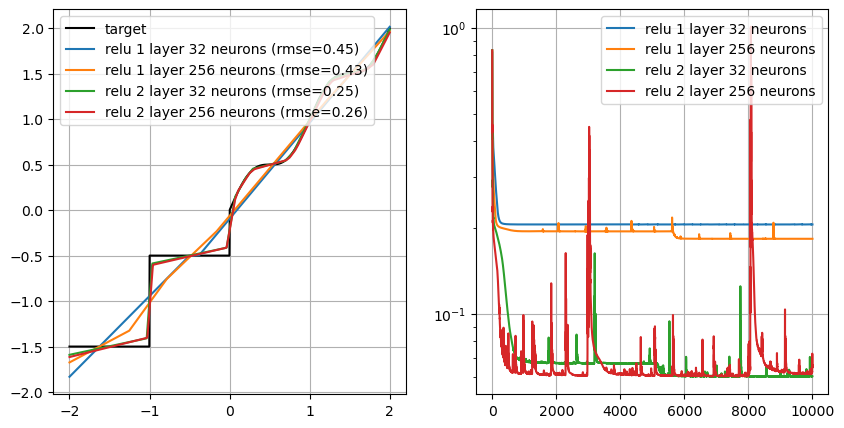

In [6]:
models = {
    "relu 1 layer 32 neurons": MonotonicMLP(
        dims=(1, 32, 1), 
        activation=nn.LeakyReLU(),
    ),
    "relu 1 layer 256 neurons": MonotonicMLP(
        dims=(1, 256, 1),
        activation=nn.LeakyReLU(),
    ),
    "relu 2 layer 32 neurons": MonotonicMLP(
        dims=(1, 32, 32, 1), 
        activation=nn.LeakyReLU(),
    ),
    "relu 2 layer 256 neurons": MonotonicMLP(
        dims=(1, 256, 256, 1),
        activation=nn.LeakyReLU(),
    ),
}
train(models, hard=False, lr=0.01, steps=10000)
train(models, hard=True, lr=0.01, steps=10000)